## About Dataset


<b>Context<b>:
<br>
According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.


### <b>Attribute Information<b>
1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

### Importing Necessary Libraries

In [1]:
# Importing necessary libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
import scipy.stats as stats
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.feature_selection import RFE
from scipy.stats.mstats import winsorize
from sklearn.linear_model import LogisticRegression, RidgeClassifier, LinearRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import RandomizedSearchCV
import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings("ignore")

### Loading In the Dataset

In [2]:
data = pd.read_csv('stroke.csv')
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


## EDA

In [3]:
# Getting information about the dataset.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Lets take a look at the unique values in the columns of the dataset, to verify if the values are in line with the data types.

In [4]:
def checking_unique_values(dataframe):
    # A function to loop over the column and see the unique values in each of the columns
    for column in dataframe.columns:
        print(column)
        print('-' * 80, '\n')
        print(dataframe[column].unique())
        print('\n \n')

In [5]:
checking_unique_values(data)

id
-------------------------------------------------------------------------------- 

[ 9046 51676 31112 ... 19723 37544 44679]

 

gender
-------------------------------------------------------------------------------- 

['Male' 'Female' 'Other']

 

age
-------------------------------------------------------------------------------- 

[6.70e+01 6.10e+01 8.00e+01 4.90e+01 7.90e+01 8.10e+01 7.40e+01 6.90e+01
 5.90e+01 7.80e+01 5.40e+01 5.00e+01 6.40e+01 7.50e+01 6.00e+01 5.70e+01
 7.10e+01 5.20e+01 8.20e+01 6.50e+01 5.80e+01 4.20e+01 4.80e+01 7.20e+01
 6.30e+01 7.60e+01 3.90e+01 7.70e+01 7.30e+01 5.60e+01 4.50e+01 7.00e+01
 6.60e+01 5.10e+01 4.30e+01 6.80e+01 4.70e+01 5.30e+01 3.80e+01 5.50e+01
 1.32e+00 4.60e+01 3.20e+01 1.40e+01 3.00e+00 8.00e+00 3.70e+01 4.00e+01
 3.50e+01 2.00e+01 4.40e+01 2.50e+01 2.70e+01 2.30e+01 1.70e+01 1.30e+01
 4.00e+00 1.60e+01 2.20e+01 3.00e+01 2.90e+01 1.10e+01 2.10e+01 1.80e+01
 3.30e+01 2.40e+01 3.40e+01 3.60e+01 6.40e-01 4.10e+01 8.80e-01 5.00e+00
 2.6

Each columns in the dataset is in line with its datatypes.

In [6]:
# Getting the shape of the dataset
print('There are {} rows and {} columns in the dataset'.format(
    data.shape[0], data.shape[1]))

There are 5110 rows and 12 columns in the dataset


In [7]:
# Checking the percentage of missing values in each of the columns in the dataset.
missing_df = pd.DataFrame((data.isnull().mean()*100),
                          columns=['missing value(%)'])
missing_df

,missing value(%)
id,0.000000
gender,0.000000
age,0.000000
hypertension,0.000000
heart_disease,0.000000
ever_married,0.000000
work_type,0.000000
Residence_type,0.000000
avg_glucose_level,0.000000
bmi,3.933464


Only the bmi features has missing values which makes up almost 4% of its values

In [8]:
# Checking for duplicated rows or samples
print('There are {} duplicated rows'.format(data.duplicated().sum()))

There are 0 duplicated rows


In [9]:
df = data.copy()

The datatypes of some of the columns in the dataset will now be changed to the categorical type to reflect the nature of its values.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [11]:
df['gender'] = df['gender'].astype('category')
df['hypertension'] = df['hypertension'].astype('category')
df['heart_disease'] = df['heart_disease'].astype('category')
df['stroke'] = df['stroke'].astype('category')
df['work_type'] = df['work_type'].astype('category')
df['Residence_type'] = df['Residence_type'].astype('category')
df['smoking_status'] = df['smoking_status'].astype('category')
df['ever_married'] = df['ever_married'].astype('category')

In [12]:
# Checking out the effect of changing the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 5110 non-null   int64   
 1   gender             5110 non-null   category
 2   age                5110 non-null   float64 
 3   hypertension       5110 non-null   category
 4   heart_disease      5110 non-null   category
 5   ever_married       5110 non-null   category
 6   work_type          5110 non-null   category
 7   Residence_type     5110 non-null   category
 8   avg_glucose_level  5110 non-null   float64 
 9   bmi                4909 non-null   float64 
 10  smoking_status     5110 non-null   category
 11  stroke             5110 non-null   category
dtypes: category(8), float64(3), int64(1)
memory usage: 200.9 KB


In [13]:
# Getting summary statistics of the numerical columns in the dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60


- The mean age of patients is 43 years while the maximum is 82 years. The minimum age of the patients is a baby aged 0.08 years giving an age in days of 29 days.
- The minimum BMI is 10.3 while the maximum BMI is 97.60. The mean or average BMI is 28.1.

In [14]:
# Getting summary statistics of the categorical columns in the dataset.
df.describe(exclude=['int', 'float'])

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke
count,5110,5110,5110,5110,5110,5110,5110,5110
unique,3,2,2,2,5,2,4,2
top,Female,0,0,Yes,Private,Urban,never smoked,0
freq,2994,4612,4834,3353,2925,2596,1892,4861


- There are 3 unique categories in the gender feature with female being the most popular with a frequency of 2994.
- Most of the patients work in the private sector (2925 patients).

## Data Visualization 

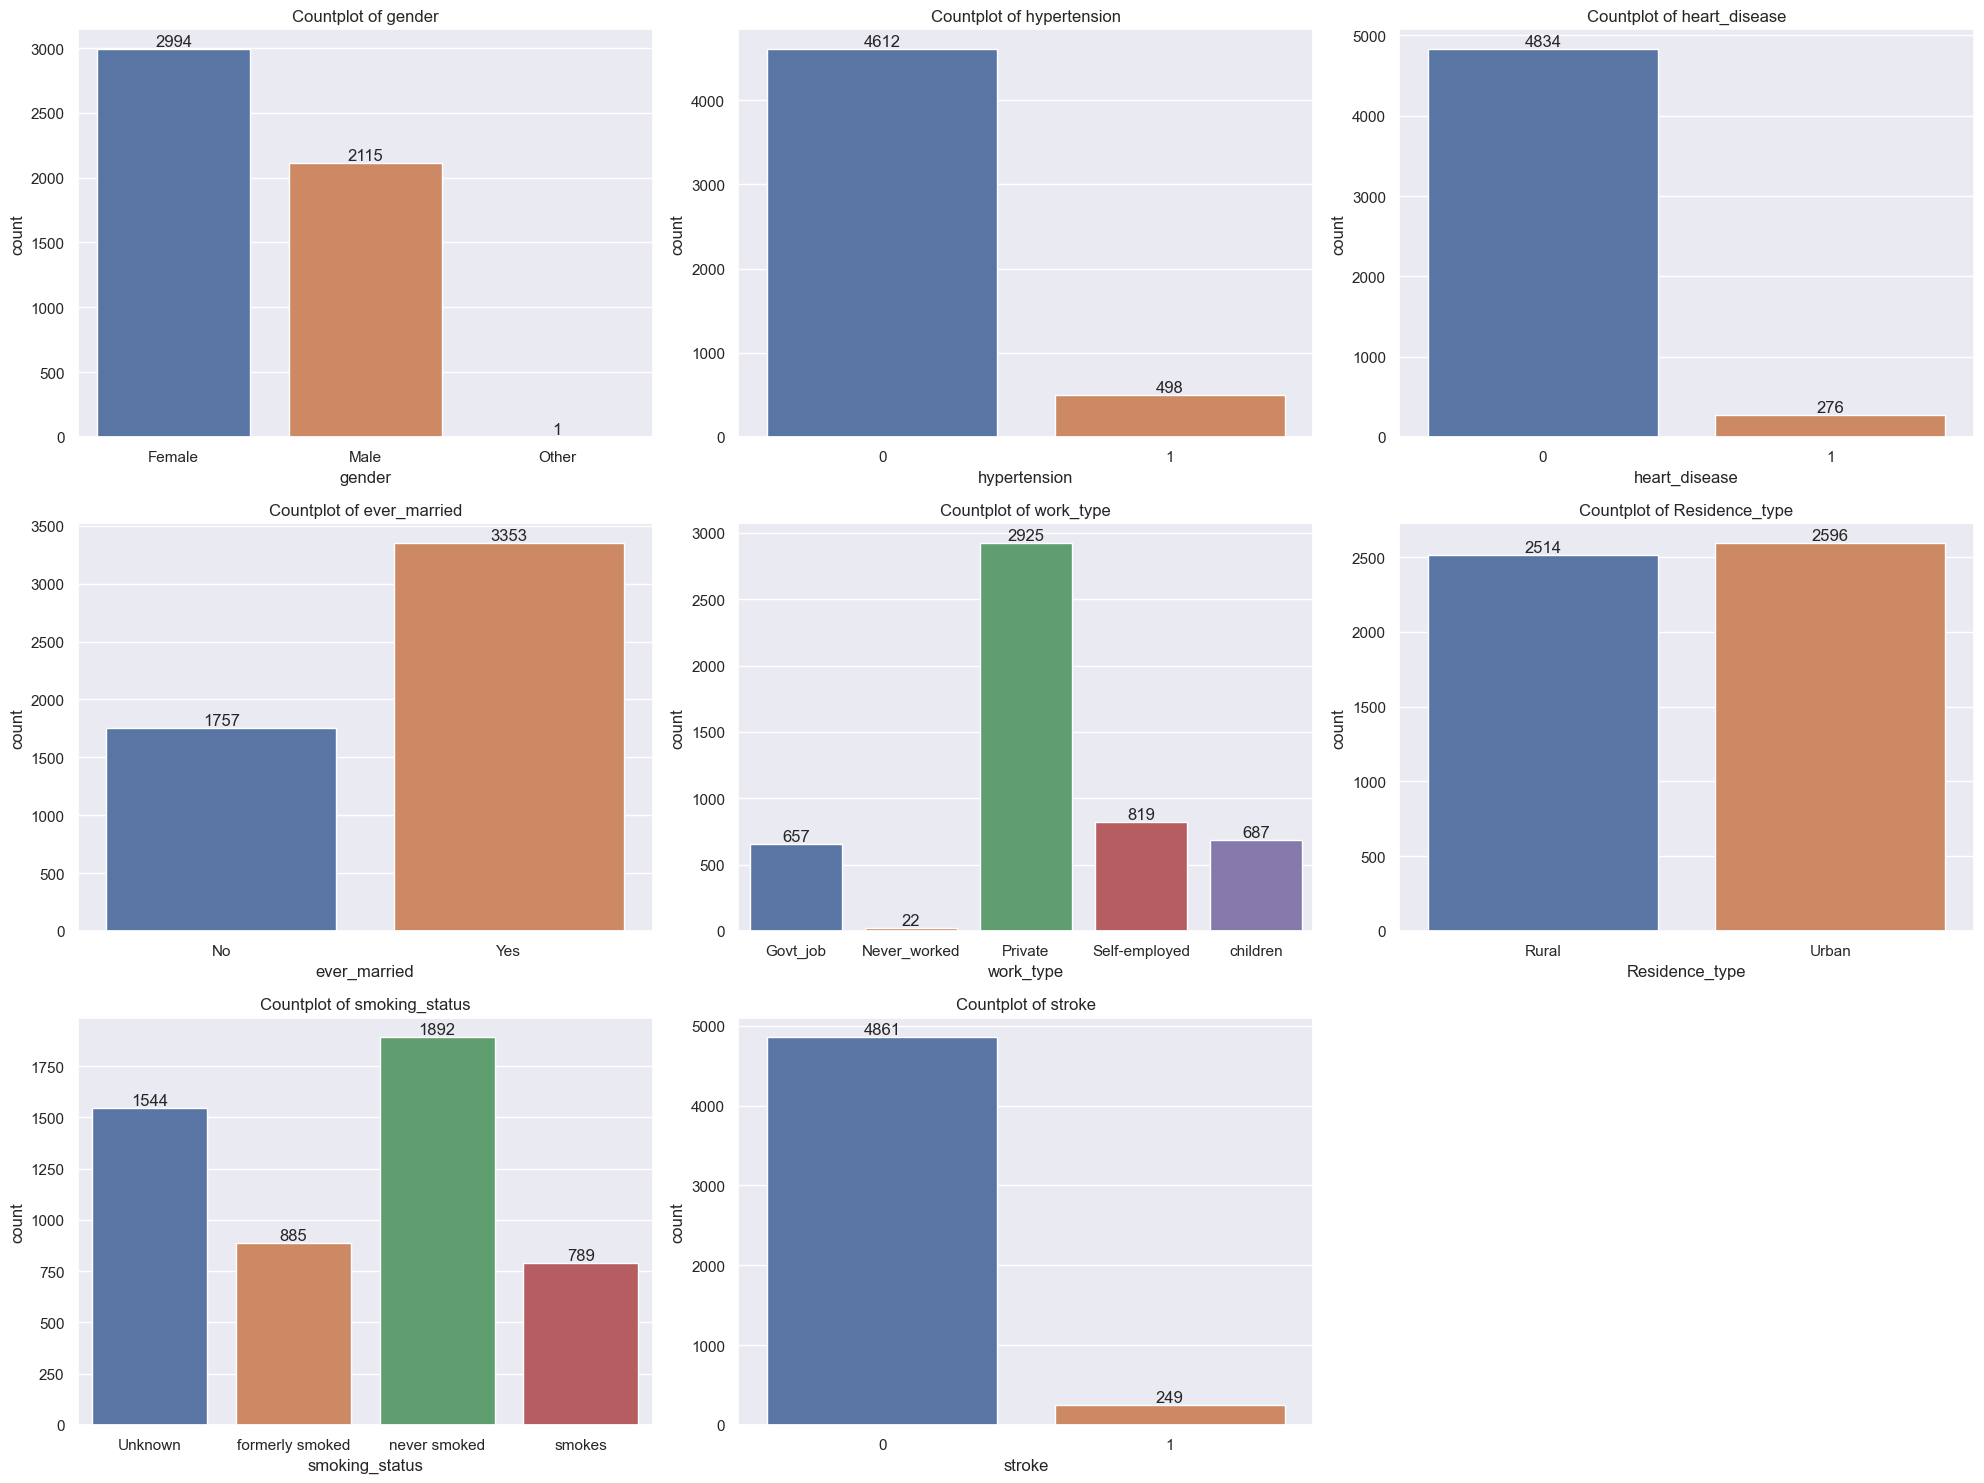

In [15]:
cat_df = df.select_dtypes(exclude=['int', 'float']).columns

#  Categorical Data
a = 3  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter
sns.set()
fig = plt.figure(figsize=(20, 15))
for i in cat_df:
    plt.subplot(a, b, c)
    plt.title('Countplot of {}'.format(i))
    plt.xlabel(i)
    ax = sns.countplot(data=df, x=i)
    for container in ax.containers:
        ax.bar_label(container)
    c = c + 1

plt.tight_layout()
plt.show()

- 4612 patients do not have hypertension which makes up (90.2%) of the total patients.
- 4834 patients do not have any occurence of heart disease which makes up (94.5%) of the total patients.
- 3353 out of the total 5110 patients have gotten married at least once.
- 249 out of the total 5110 patients has stroke.
- There is only one with the gender 'Other'.

Now lets take a look into a subset of the dataset for patients with work type 'children' and 'Never_worked'

In [16]:
df[df.work_type == 'children'].describe().T

,count,mean,std,min,25%,50%,75%,max
id,687.0,35769.432314,21005.291797,77.00,16583.000,35106.00,53933.50,72940.00
age,687.0,6.841339,4.533364,0.08,2.000,6.00,11.00,16.00
avg_glucose_level,687.0,94.400277,26.658955,55.34,76.255,90.22,108.71,219.81
bmi,671.0,20.038003,4.540639,10.30,17.150,18.90,21.60,41.70


In [17]:
df[df.work_type == 'Never_worked'].describe().T

,count,mean,std,min,25%,50%,75%,max
id,22.0,38274.409091,20166.419938,11702.00,19830.7500,36054.50,57202.0000,71966.00
age,22.0,16.181818,2.342899,13.00,14.2500,16.00,17.0000,23.00
avg_glucose_level,22.0,96.042727,28.697132,59.99,78.4575,86.02,112.8075,161.28
bmi,22.0,25.545455,7.441757,14.60,20.9750,23.15,28.3500,44.90


Patients with work type children are basically children below the ages of 17 while patients with work type 'never_worked' are basically teenagers and youths of student age.

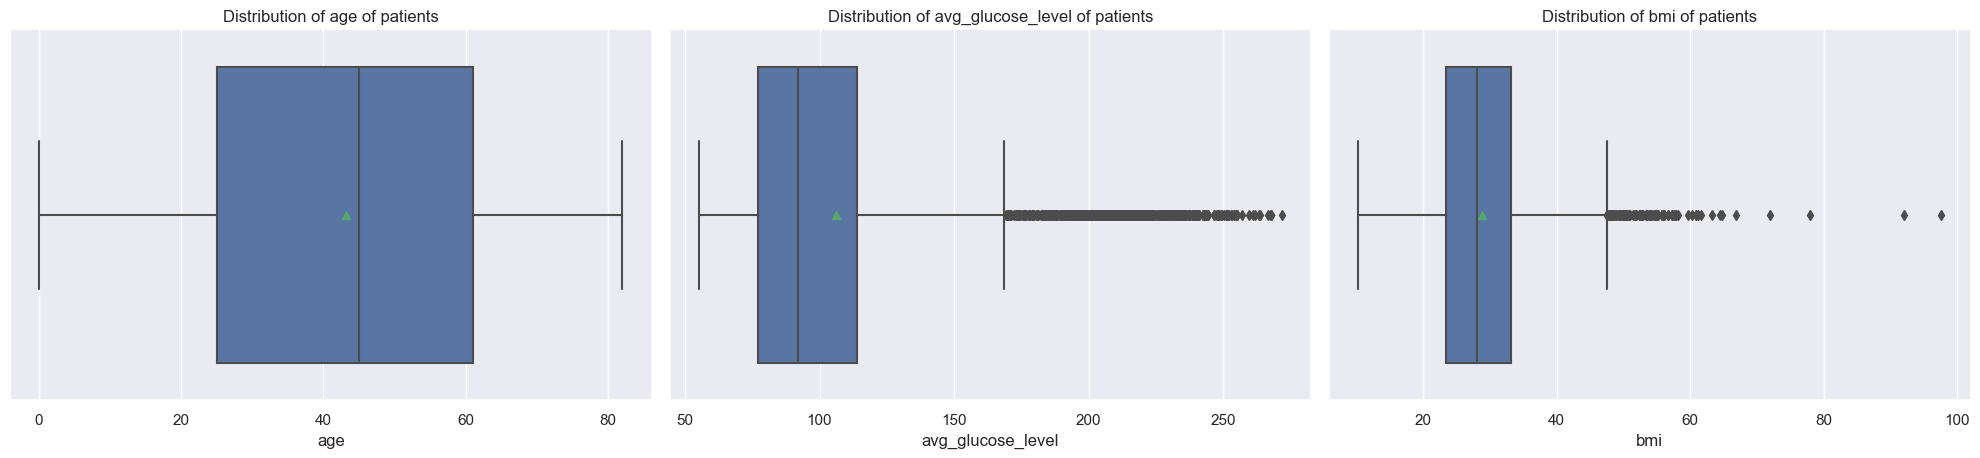

In [18]:
num_df = df.drop('id', axis=1).select_dtypes(include=['int', 'float']).columns

#  Categorical Data
a = 3  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(20, 13))
for i in num_df:
    plt.subplot(a, b, c)
    plt.title('Distribution of {} of patients'.format(i))
    plt.xlabel(i)
    sns.boxplot(data=df, x=i, showmeans=True)
    c = c + 1

plt.tight_layout()
plt.show()

- The average glucose level and the bmi features has some heavy presence of outliers and are right skewed due to the presence of these outliers.

### Patients with Stroke vs Patients without Stroke 


In this section, we will observe the characteristics of patients with stroke and patients without stroke using both the numerical features.


1. Ages of Patients within the two groups
***

In [19]:
def pivot_analysis(data, col1, col2):
    print(pd.pivot_table(df, index=col1, values=col2, aggfunc=np.mean))
    plt.figure(figsize=(15, 8))
    sns.boxplot(data=df, x=col1, y=col2, showmeans=True)
    plt.title(
        'Distribution of {} for patients with stroke and patients without stroke'.format(col2))

              age
stroke           
0       41.971545
1       67.728193


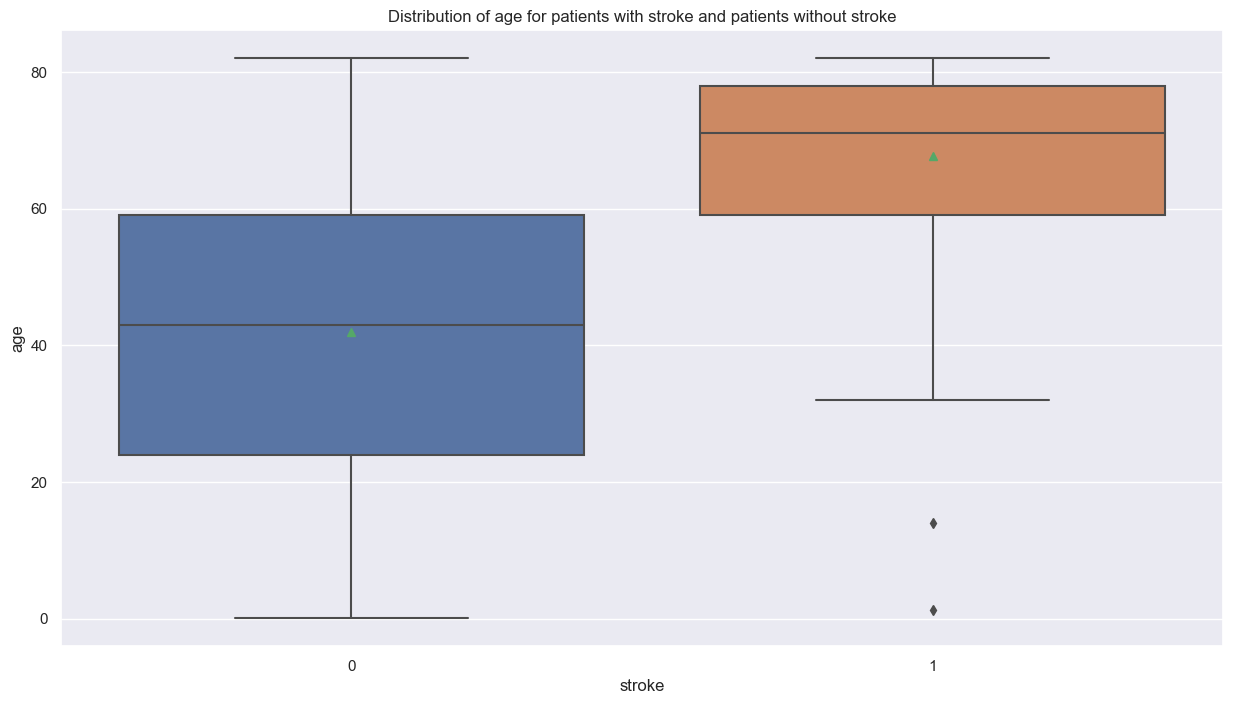

In [20]:
# Observing the mean age of patients and distribution for with stroke and patients without stroke
pivot_analysis(df, 'stroke', 'age')

The mean age of patients without stroke is 42 years while the mean age of patients with stroke is 68 years. Looking at the chart above gives a description of the distribution of the two groups. The interquartile range for patients with stroke ranges from a little below 60 years to almost 80 years of age.

2. BMI of Patients within the two groups
***

              bmi
stroke           
0       28.823064
1       30.471292


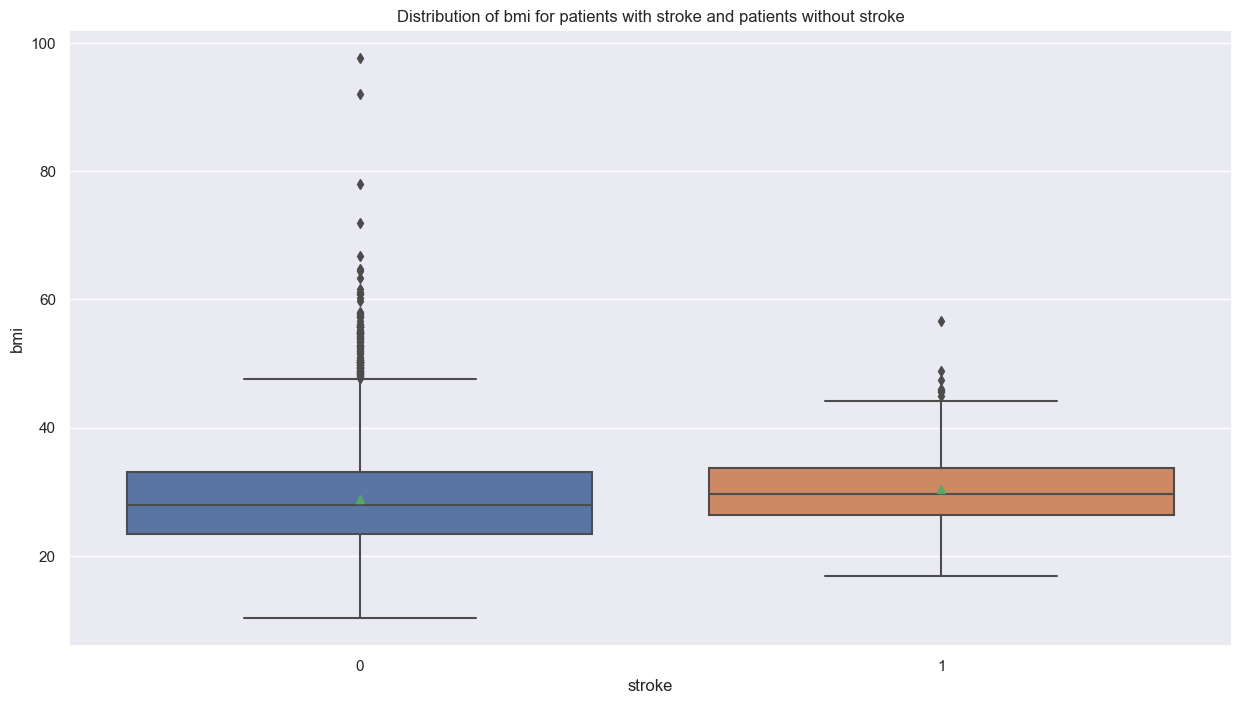

In [21]:
# Observing the mean bmi and distribution of bmi for patients with stroke and patients without stroke
pivot_analysis(df, 'stroke', 'bmi')

The mean bmi for patients with stroke is 30.5 while the mean bmi for patients without stroke is 28.8. The median bmi is higher for patients without stroke. The distribution of bmi for patients without stroke is skewed with outliers which may have affected the mean value

3. Average Glucose Level of Patients within the two groups
***

        avg_glucose_level
stroke                   
0              104.795513
1              132.544739


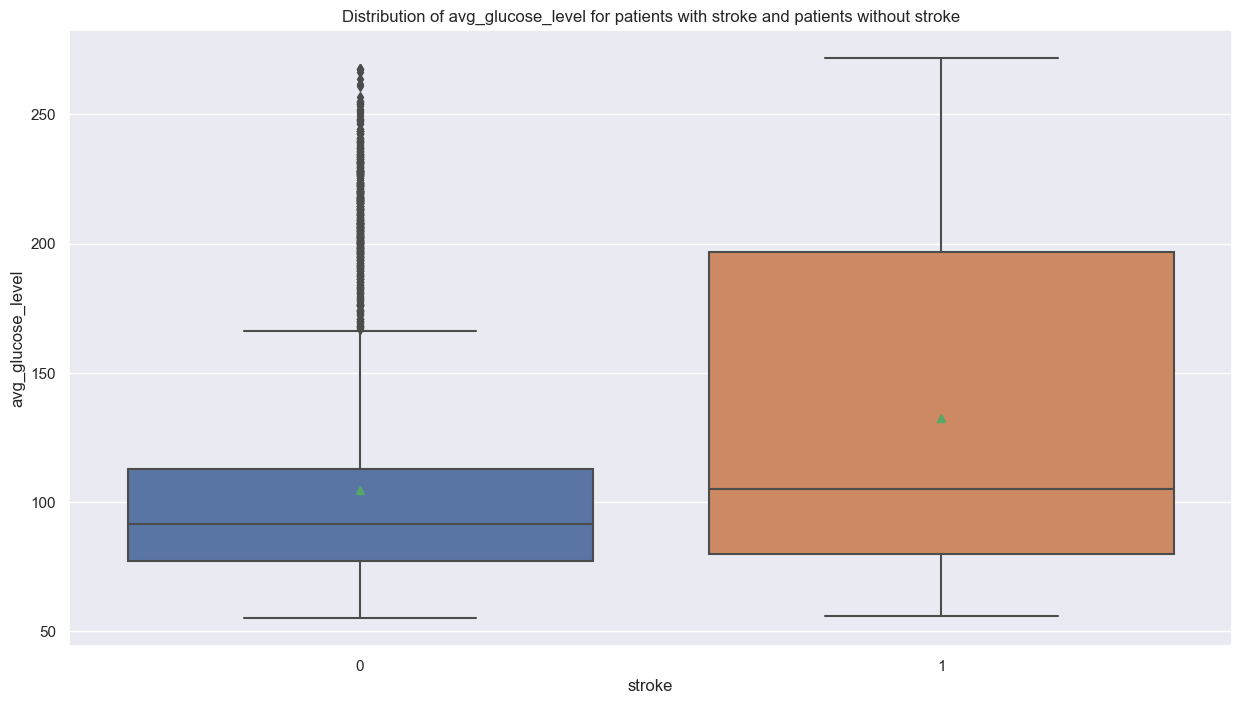

In [22]:
pivot_analysis(df, 'stroke', 'avg_glucose_level')

The mean glucose level for patients with stroke is 132.5 while the mean bmi for patients without stroke is 104.8. The distribution of bmi for patients without stroke is skewed with outliers which may have affected the mean value. There is a huge count of average glucose levels above 100 for patients with stroke. This can be seen in the interquartile range of the boxplot.

In [23]:
def crosstab_analysis(data, col1, col2):
    print(pd.crosstab(df[col1], df[col2], margins=True))
    plt.figure(figsize=(15, 8))
    sns.countplot(data=df, x=col2, hue=col1)
    plt.title(
        'Counts of {} for patients with stroke and patients without stroke'.format(col2))

gender  Female  Male  Other   All
stroke                           
0         2853  2007      1  4861
1          141   108      0   249
All       2994  2115      1  5110


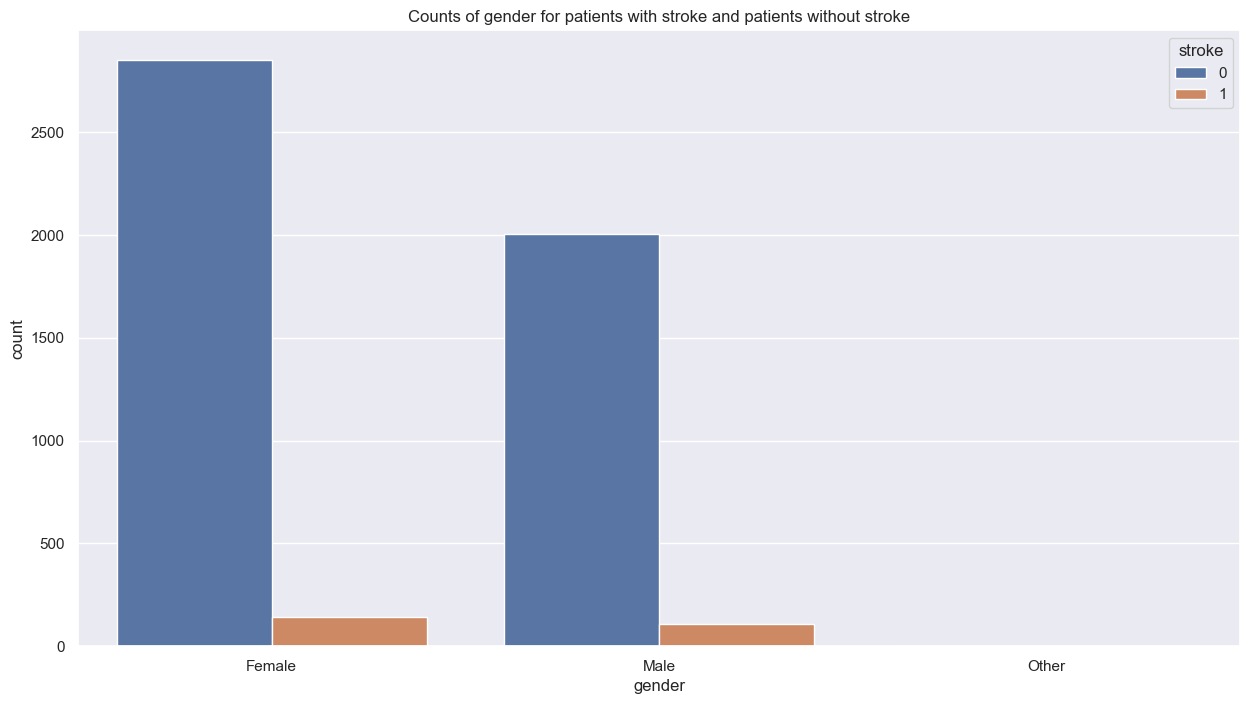

In [24]:
crosstab_analysis(df, 'stroke', 'gender')

- 141 females patients had stroke while 2853 female patients did not have stroke.
- 108 male patients had stroke while 2007 males patients did not.
- For all groups, i.e patients with stroke and patients without stroke, there are more female than males. 
- Males are more likely to have stroke (5.11%) compared to females (4.71%).

hypertension     0    1   All
stroke                       
0             4429  432  4861
1              183   66   249
All           4612  498  5110


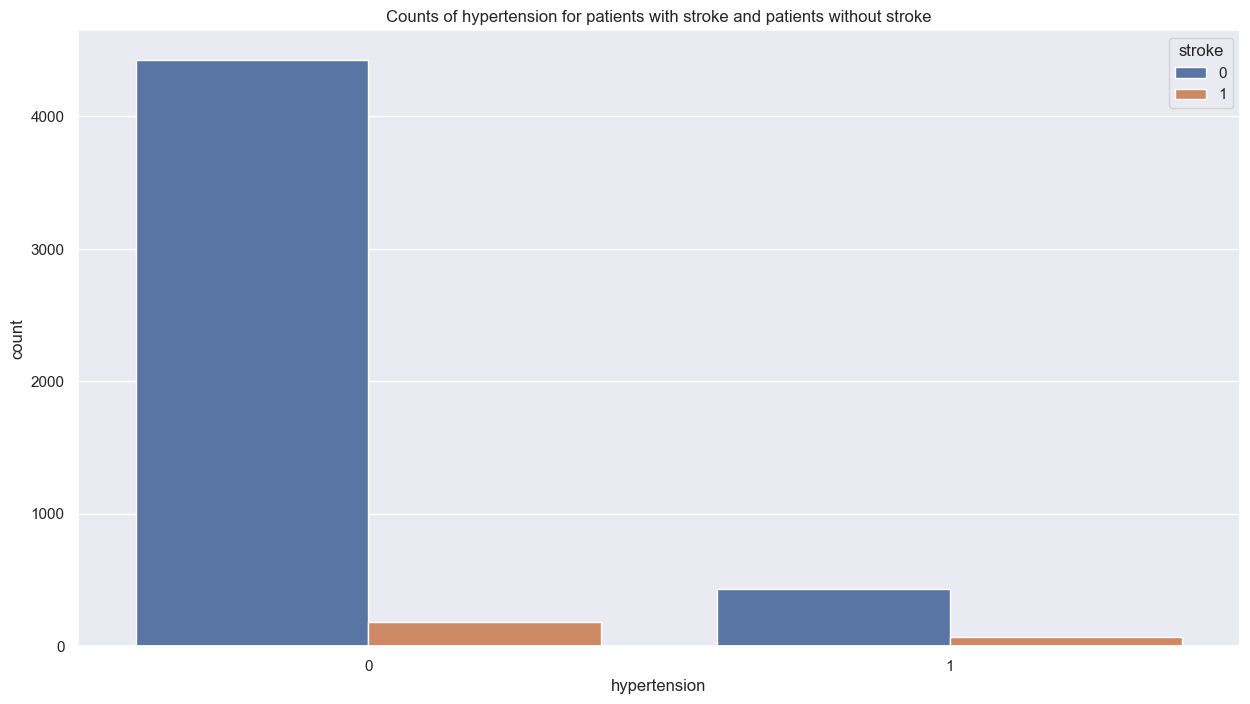

In [25]:
crosstab_analysis(df, 'stroke', 'hypertension')

- Patients with hypertension are most at risk (13.2%) for developing stroke, compared to people with no hypertension (3.96%).

- 4429 patients did not have hypertension and stroke.
- 183 patients have stroke but not hypertension.
- 432 patients have stroke but not hypertension.
- 66 patients had both hypertension and stroke.

heart_disease     0    1   All
stroke                        
0              4632  229  4861
1               202   47   249
All            4834  276  5110


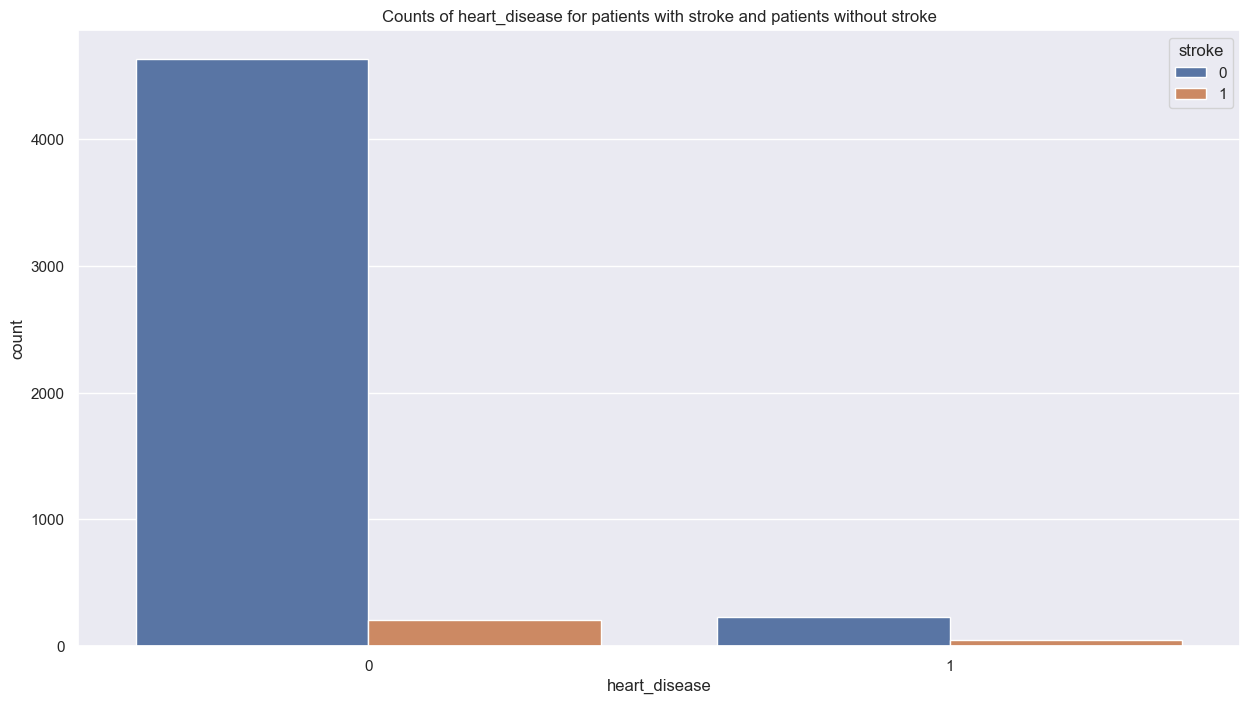

In [26]:
crosstab_analysis(df, 'stroke', 'heart_disease')

- 4632 patients did not have heart disease and stroke.
- 202 patients have stroke but not heart disease.
- 229 patients have stroke but not heart disease.
- 47 patients had both heart disease and stroke.
- Patients with heart disease are most at risk (17.03%) for developing stroke, compared to people with no heart disease (4.18%).

ever_married    No   Yes   All
stroke                        
0             1728  3133  4861
1               29   220   249
All           1757  3353  5110


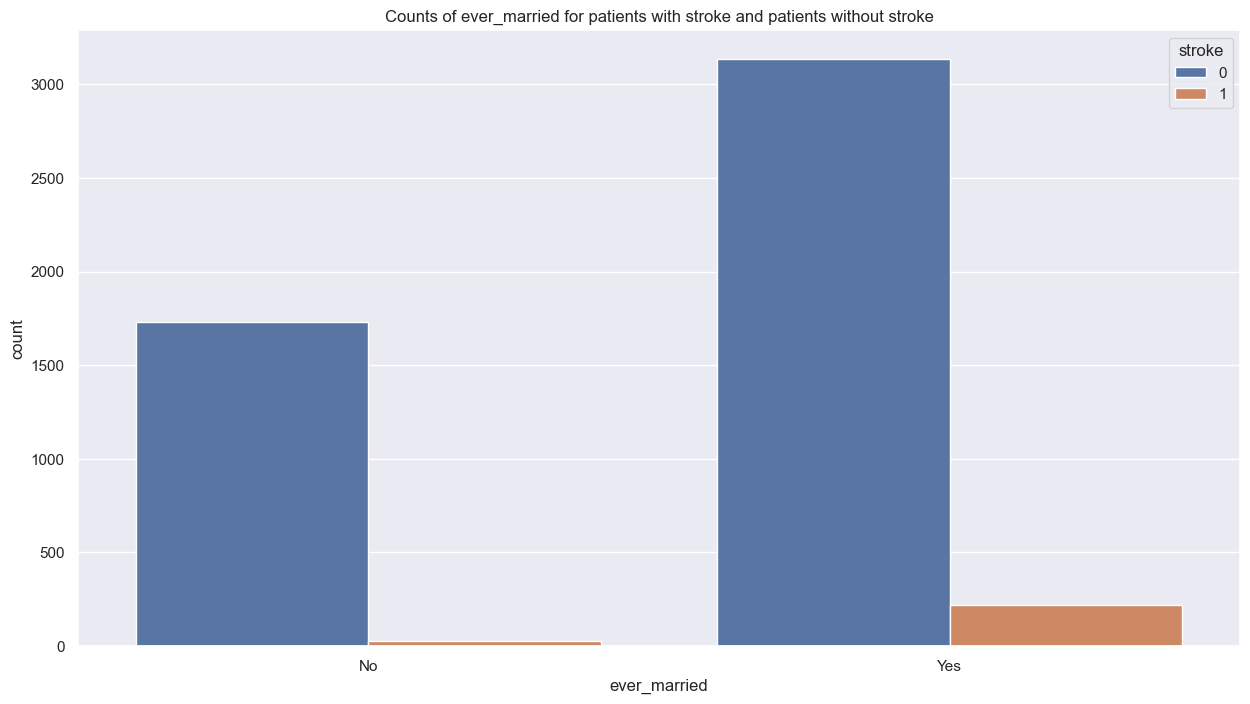

In [27]:
crosstab_analysis(df, 'stroke', 'ever_married')

- Married people (6.6%) are more likely to have stroke than single people (1.7%)

work_type  Govt_job  Never_worked  Private  Self-employed  children   All
stroke                                                                   
0               624            22     2776            754       685  4861
1                33             0      149             65         2   249
All             657            22     2925            819       687  5110


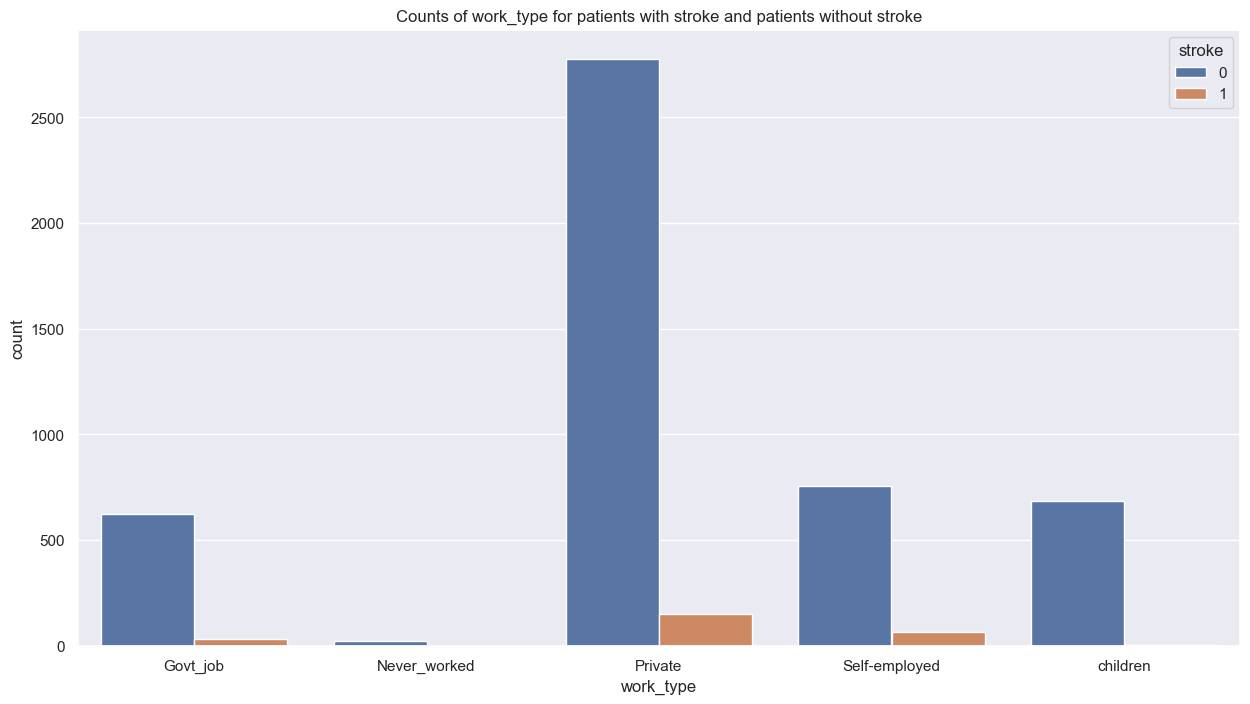

In [28]:
crosstab_analysis(df, 'stroke', 'work_type')

- Out of all the patients who had never worked, none of them had stroke while for the patients who are children, only two had stroke. Does this mean that stroke is related to the type of work one does?
- Patients who are self employed has a higher rate of having stroke (7.9%) as compared to government workers (5.02%) and private working patients (5.09).

In [29]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

smoking_status  Unknown  formerly smoked  never smoked  smokes   All
stroke                                                              
0                  1497              815          1802     747  4861
1                    47               70            90      42   249
All                1544              885          1892     789  5110


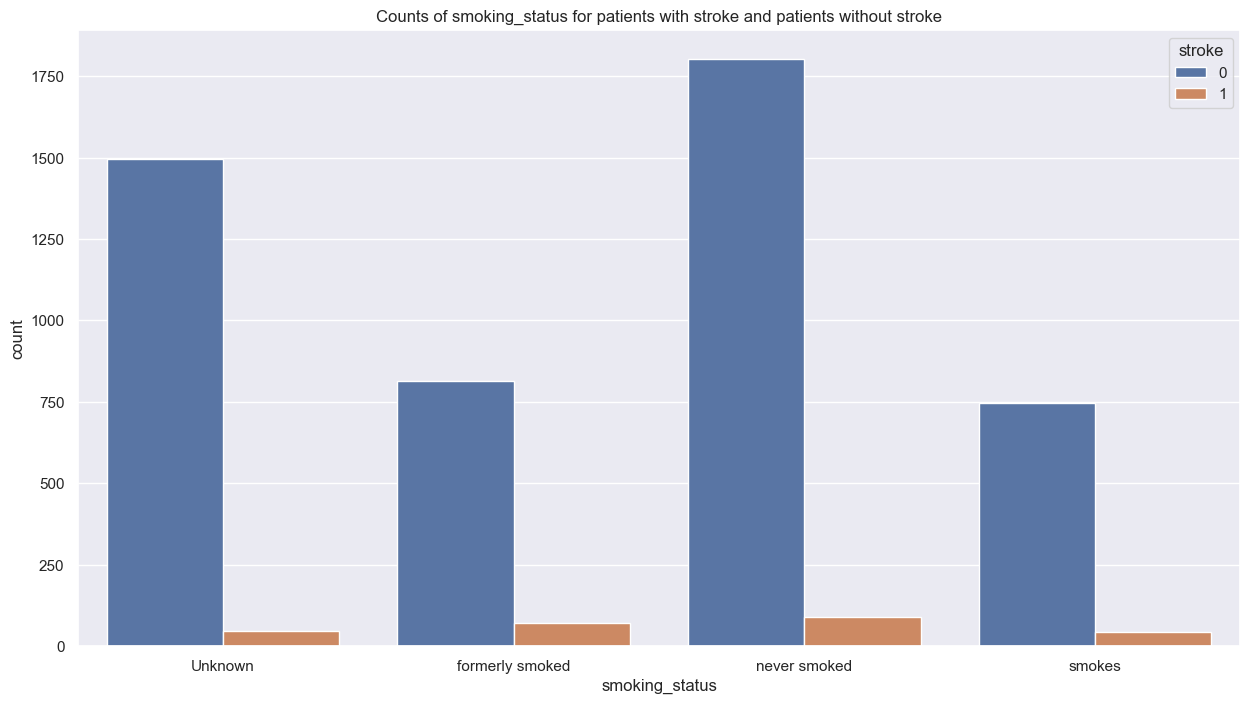

In [30]:
crosstab_analysis(df, 'stroke', 'smoking_status')

- Patients who formerly smoked are at high risk(7.9%) of having stroke than all other categories.

## Hypothesis Testing

### T-Test

In this section, we will carry out the ttest to determine if the distribution of features are the same above groups of patients with stroke and patients without stroke

- Null Hypothesis : The distribution of the numerical feature across both groups are the same.
- Alternate Hypothesis : The distribution of the numerical feature of patients with stroke is greater than that of patients without stroke.
- Alpha = 0.05.

Note: If the p value is greater than alpha(0.05), we accept the null hypothesis and if the p value is lesser than alpha(0.05), we reject the null hypothesis.

In [31]:
# A function to perform the ttest between columns in the dataframe
def pairwise_ttest(data, num_cols, cat_cols):
    t_test_matrix = pd.DataFrame(index=num_cols, columns=cat_cols)
    for num_col in num_cols:
        for cat_col in cat_cols:
            for cat_val in data[cat_col].unique():
                group1 = data[data[cat_col] == cat_val][num_col]
                group2 = data[data[cat_col] != cat_val][num_col]
                t_stat, p_val = stats.ttest_ind(
                    group1, group2, equal_var=False, nan_policy='omit', alternative='less')
                t_test_matrix.at[num_col, cat_col] = round(p_val, 6)
    return t_test_matrix

In [32]:
num_cols = df.select_dtypes(include=['int', 'float']).drop(
    'id', axis=1).dropna().columns
cat_col = ['stroke']

In [33]:
ttest = pairwise_ttest(df, num_cols, cat_col)
ttest

,stroke
age,0.0
avg_glucose_level,0.0
bmi,0.000167


The p-value for all the numerical features for patients between both groups is lesser than 0.05. So we reject the null hypothesis and say the ages, average glucose level and bmi for patients with stroke is higher than the ages, average glucose level and bmi of patients without stroke.

### Chisquare Contingency Test for Association.

In this section, we will carry out the ttest to determine if there are any association between categorical features in the dataset. 

- Null Hypothesis : There is an association between the two columns.
- Alternate Hypothesis : There is no association between the two columns.
- Alpha = 0.05.

Note: If the p value is greater than alpha(0.05), we accept the null hypothesis and if the p value is lesser than alpha(0.05), we reject the null hypothesis.

In [34]:
cat_df = df.select_dtypes(include=['category'])

In [35]:
# Perform chi-square test for each pair of columns
def pairwise_chi_square_test(df):
    columns = df.columns
    num_columns = len(columns)
    p_values = {}

    for i in range(num_columns):
        for j in range(i + 1, num_columns):
            contingency_table = pd.crosstab(df[columns[i]], df[columns[j]])
            chi2, p, _, _ = stats.chi2_contingency(contingency_table)
            p_values[(columns[i], columns[j])] = p

    return p_values

In [36]:
p_values = pairwise_chi_square_test(cat_df)
print("Pairwise Chi-Square Test P-Values:")
print('-' * 50, '\n')
for pair, p_value in p_values.items():
    print(f"{pair}: {p_value}, \n")

Pairwise Chi-Square Test P-Values:
-------------------------------------------------- 

('gender', 'hypertension'): 0.2997575712141295, 

('gender', 'heart_disease'): 6.934608951158923e-09, 

('gender', 'ever_married'): 0.03765357700623182, 

('gender', 'work_type'): 8.503150002091437e-07, 

('gender', 'Residence_type'): 0.5424771131010444, 

('gender', 'smoking_status'): 1.5603072385938315e-10, 

('gender', 'stroke'): 0.7895490538408245, 

('hypertension', 'heart_disease'): 2.208889768960281e-14, 

('hypertension', 'ever_married'): 1.4146755500784048e-31, 

('hypertension', 'work_type'): 3.006680768703227e-28, 

('hypertension', 'Residence_type'): 0.6041003928812094, 

('hypertension', 'smoking_status'): 2.282023219070668e-22, 

('hypertension', 'stroke'): 1.661621901511823e-19, 

('heart_disease', 'ever_married'): 4.289366472610616e-16, 

('heart_disease', 'work_type'): 1.613111898301022e-14, 

('heart_disease', 'Residence_type'): 0.8735621790649243, 

('heart_disease', 'smoking_stat

- There is an association between the 'gender' column and the 'stroke' column.(p value of 0.79)
- There is an association the residence type column and the stroke column.(p value of 0.30)
- There is an association between the gender column and the residence type column(p value of 0.54).
- There is an association between the gender column and hypertension column.

### Cramers V Test.

In this section, test for the degree of statistical association between the categorical columns are carried out using the Cramers V test for association.


Note: Statistical association does not in any way denote causation. Just because there is a high degree of association between two features does not mean one feature causes another. It just means that changes in the value of one feature is consistent with the change in value for another feature.



                Cramer's V               Relationship type
                -------------------|----------------------------
                < 0.10             |           Weak association
                > 0.10 and < 0.25  |           Moderate association
                > 0.25 and < 1     |           Strong association
                1                  |           Perfect association


In [37]:
def pairwise_cramers(df):
    columns = df.columns
    num_columns = len(columns)
    cramers_v = {}

    for i in range(num_columns):
        for j in range(i + 1, num_columns):
            contingency_table = pd.crosstab(df[columns[i]], df[columns[j]])
            pval = stats.contingency.association(
                contingency_table, method='cramer')
            p_values[(columns[i], columns[j])] = pval

    return p_values

In [38]:
p_values = pairwise_cramers(cat_df)
print("Pairwise Cramers V Test P-Values:")
print('-' * 50, '\n')
for pair, p_value in p_values.items():
    print(f"{pair}: {p_value}, \n")

Pairwise Cramers V Test P-Values:
-------------------------------------------------- 

('gender', 'hypertension'): 0.0217149404947506, 

('gender', 'heart_disease'): 0.08574923886396581, 

('gender', 'ever_married'): 0.035825885329810944, 

('gender', 'work_type'): 0.06492130469899787, 

('gender', 'Residence_type'): 0.015471827592015017, 

('gender', 'smoking_status'): 0.07490264201603085, 

('gender', 'stroke'): 0.009616792928620093, 

('hypertension', 'heart_disease'): 0.10830607646088994, 

('hypertension', 'ever_married'): 0.16424309290689423, 

('hypertension', 'work_type'): 0.16265872695002398, 

('hypertension', 'Residence_type'): 0.00791345451388423, 

('hypertension', 'smoking_status'): 0.14257500551076416, 

('hypertension', 'stroke'): 0.1279038234664802, 

('heart_disease', 'ever_married'): 0.11464406209801303, 

('heart_disease', 'work_type'): 0.11762698489820629, 

('heart_disease', 'Residence_type'): 0.0030920209783136597, 

('heart_disease', 'smoking_status'): 0.0934828

### Correlation Test.

<Axes: >

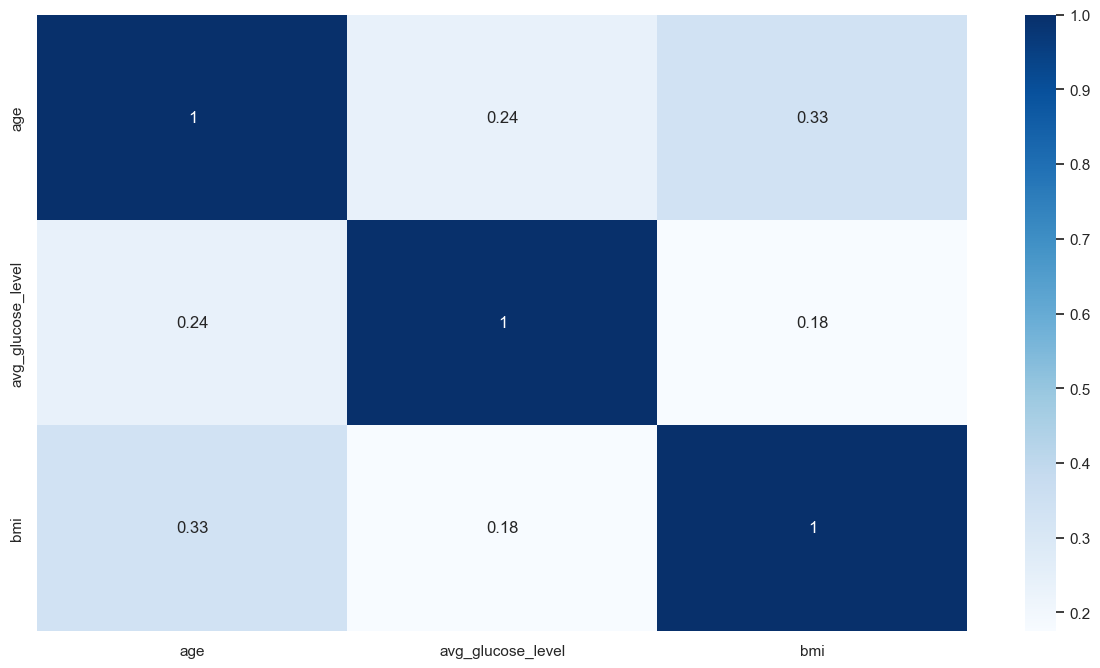

In [39]:
# Getting a correlation plot of all numerical features in the dataset.
plt.figure(figsize=(15, 8))
sns.heatmap(df.drop('id', axis=1).corr(), annot=True, cmap='Blues')

- There is a weak positive correlation between the average glucose level of patients and age (0.24). This shows that average glucose level for patients increases with increasing age.
- There is also a presence of a weak correlation between the bmi value of patients and the age of patients (0.33). This shows that the BMI value of patients increases with increasing age.

<Figure size 1500x800 with 0 Axes>

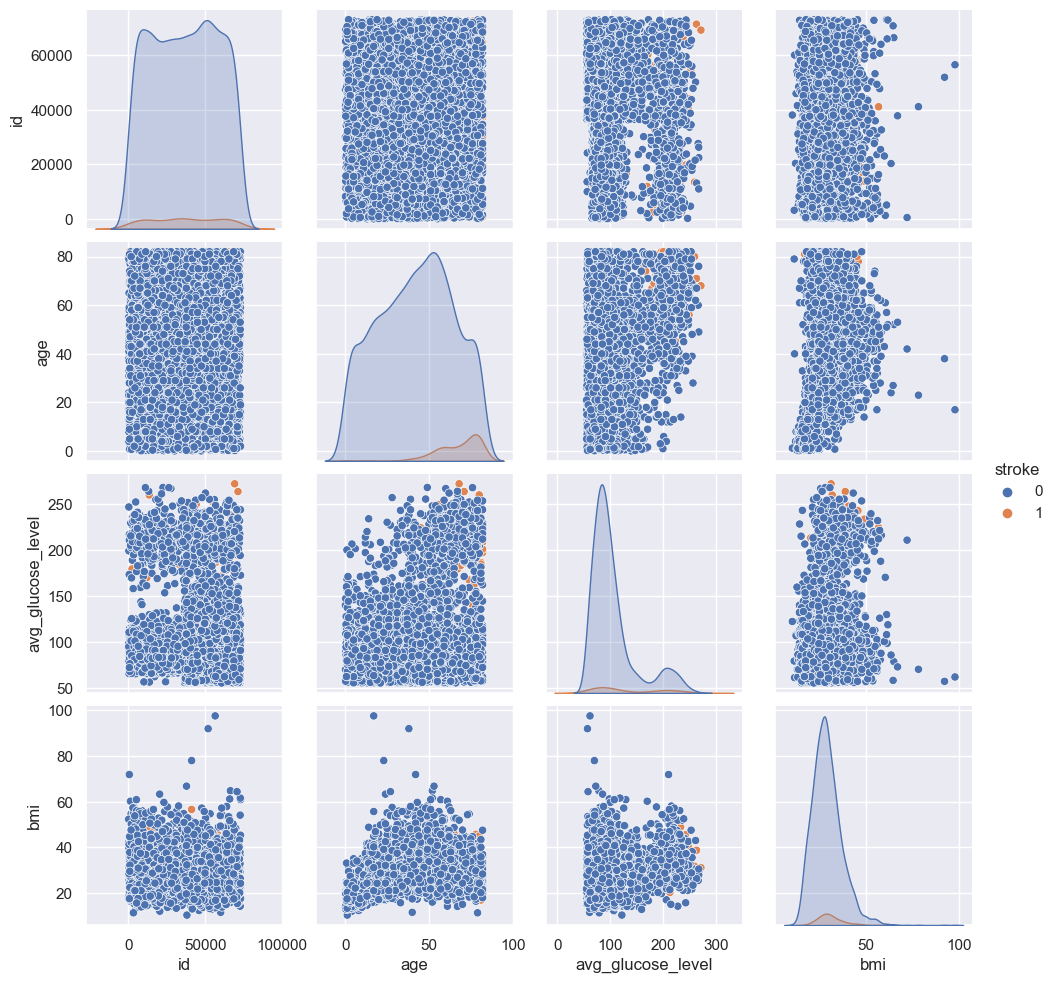

In [40]:
plt.figure(figsize=(15, 8))
sns.pairplot(df, hue='stroke')
plt.show()

## Data Preprocessing

### Missing Value Imputation.

First, we create a column called bmi_missing which holds the value 1 if the patient has a missing bmi value and 0 otherwise. This is to check if the missing values in the bmi column is related to any other features in the dataset.

In [41]:
df['bmi_missing'] = np.where(df['bmi'].isnull(), 1, 0)

<Figure size 1500x800 with 0 Axes>

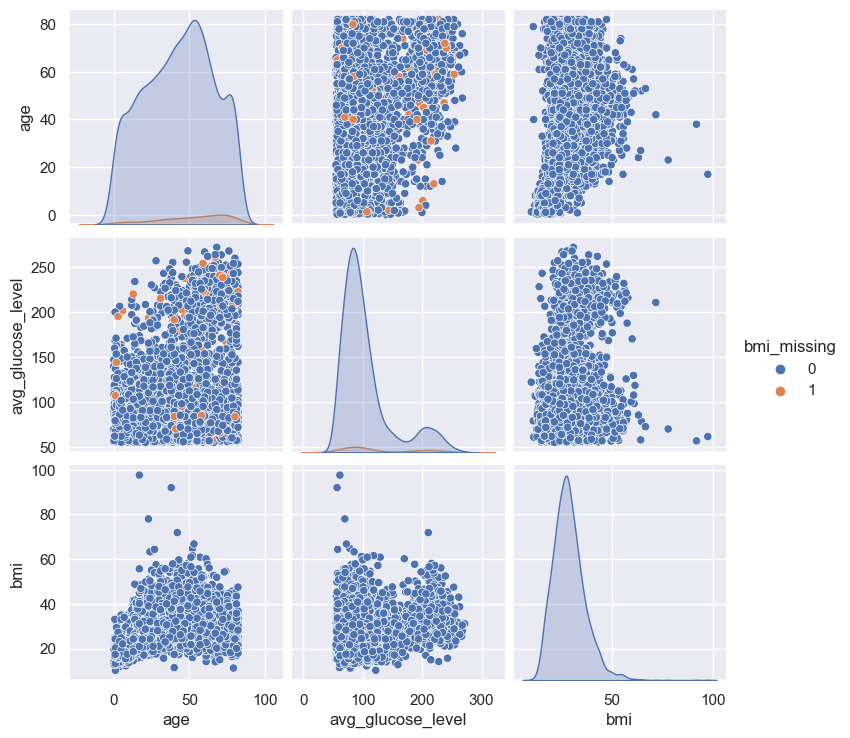

In [42]:
plt.figure(figsize=(15, 8))
sns.pairplot(df.drop('id', axis=1), hue='bmi_missing')

In [43]:
p_values = {}
for cols in cat_df.columns:
    tab = pd.crosstab(df['bmi_missing'], df[cols])
    chi2, p, _, _ = stats.chi2_contingency(tab)
    p_values[(cols, 'bmi_missing')] = p

p_values

{('gender', 'bmi_missing'): 0.009704192642183309,
 ('hypertension', 'bmi_missing'): 6.57710595728134e-11,
 ('heart_disease', 'bmi_missing'): 5.554391323283694e-12,
 ('ever_married', 'bmi_missing'): 0.011846470655162514,
 ('work_type', 'bmi_missing'): 0.038247293361581884,
 ('Residence_type', 'bmi_missing'): 0.6258417815234341,
 ('smoking_status', 'bmi_missing'): 5.82130441895745e-08,
 ('stroke', 'bmi_missing'): 3.107748528644105e-23}

Looking at the result of the chisquare contingency test of the columns, the 'work_type', 'residence_type' are associated with the missing values in the bmi column. This makes the missing values in the BMI columns missing at random (MAR). These missing values will be imputed by using a random forest regressor model to predict these values.

In [44]:
df1 = df.copy()
df1 = pd.get_dummies(df1, columns=['gender', 'hypertension', 'heart_disease', 'work_type',
                                   'Residence_type', 'ever_married', 'smoking_status'], drop_first=True)
train = df1[df1['bmi'].isnull() == False]
test = df1[df1['bmi'].isnull() == True]
model = RandomForestRegressor(random_state=105)
y = train["bmi"]
train.drop(['bmi', 'bmi_missing'], axis=1, inplace=True)
test.drop(['bmi', 'bmi_missing'], axis=1, inplace=True)
model.fit(train, y)
y_pred = model.predict(test)

In [45]:
m = df['bmi'].isnull()
df.loc[m, 'bmi'] = y_pred
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_missing
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600,formerly smoked,1,0
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,36.505,never smoked,1,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500,never smoked,1,0
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400,smokes,1,0
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000,never smoked,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,28.055,never smoked,0,1
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000,never smoked,0,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600,never smoked,0,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600,formerly smoked,0,0


The missing values have been imputed successfully.

### Feature Engineering

In [46]:
bins = [0, 18, 40, 60, np.inf]
labels = ['child', 'young', 'middle aged', 'senior']
df['age_group'] = pd.cut(df['age'], bins, labels=labels)

In [47]:
bins = [0, 70, 140, 200, np.inf]
labels = ['low', 'normal', 'high', 'risky']
df['glucose_category'] = pd.cut(df['avg_glucose_level'], bins, labels=labels)

In [48]:
bins = [0, 18, 25, 30, np.inf]
labels = ['underweight', 'healthy', 'over_weight', 'obese']
df['bmi_category'] = pd.cut(df['bmi'], bins, labels=labels)

In [49]:
stroke = pd.get_dummies(df, columns=['age_group', 'glucose_category',
                                     'bmi_category', 'smoking_status',
                                     'hypertension', 'heart_disease',
                                     'ever_married', 'work_type',
                                     'Residence_type',
                                     'gender'], drop_first=True)

In [50]:
# Splitting the dataset into independent features and target feature.
x = stroke.drop(['stroke', 'id', 'bmi_missing'], axis=1)
y = stroke['stroke']

In [51]:
# Splitting the data into training and test sets; 70% for training and 30% for testing or validating the model
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=15, stratify=y)

In [52]:
# Oversampling the minority class in the training set. This is because of the class imbalance and the few number of samples we have
ros = SMOTE(random_state=105)
x_train_ros, y_train_ros = ros.fit_resample(x_train, y_train)

## Data Modelling

This modelling task is a classification task. The performance metric of each model to be built is the 'Recall','Precision' and the Accuracy metric. The accuracy metric cannot be used due to the nature of the class imbalance in the dataset. 

- Recall shows whether a model can find all objects of a target class. The recall is the ratio of correct predicitons and the total number of correct items. It indicates how good a model is at predicting the correct class.
- Precision shows how often an ML model is correct when predicting the target class. It is the ratio between the correct predictions and the total predictions. It indicates how good a model is at whatever it predicted. 
- Accuracy represents the number of correct predictions.





The data modelling task will be done with the aid of a function. Before each model is validated on the test set, they will first be cross-validated iteratively on samples of the training dataset.

In [53]:
# Split the data using StratifiedKFold and get the average performance metrics score
def cross_validate(model, xtrain, ytrain):
    # Function for the cross validation of models.
    skf = StratifiedKFold()
    mean_f1 = 0
    mean_recall = 0
    mean_precision = 0
    mean_accuracy = 0
    for train_ix, test_ix in skf.split(xtrain, ytrain):
        X_train, X_test = xtrain.iloc[train_ix], xtrain.iloc[test_ix]
        Y_train, Y_test = ytrain.iloc[train_ix], ytrain.iloc[test_ix]
        # Import the function that computes class weights

        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        mean_f1 += f1_score(Y_test, predictions)
        mean_recall += recall_score(Y_test, predictions)
        mean_precision += precision_score(Y_test, predictions)
        mean_accuracy += accuracy_score(Y_test, predictions)

    print(f'Mean Training F1 Score: {mean_f1 / skf.n_splits}')
    print(f'Mean Training Recall Score: {mean_recall / skf.n_splits}')
    print(f'Mean Training Precision Score: {mean_precision / skf.n_splits}')
    print(f'Mean Training Accuracy Score: {mean_accuracy / skf.n_splits}')

In [54]:
def modelling(model_name, model, xtrain, ytrain, xtest, ytest):
    # A function to train and validate the model using evaluation metrics
    model.fit(xtrain.values, ytrain.values)
    pred = model.predict(xtest)
    train_score = model.score(xtrain.values, ytrain.values)
    test_score = accuracy_score(ytest, pred)
    report = classification_report(pred, ytest)
    matrix = confusion_matrix(pred, ytest)
    recall = recall_score(pred, ytest)
    precision = precision_score(pred, ytest)
    print('MODEL: {}'.format(model_name))
    print('-' * 80)
    print('Training Accuracy is : {}%'.format(round(train_score * 100), 2))
    print('Test Accuracy is {}%'.format(round(test_score * 100), 2))
    print('The classification report : \n {} '.format(report))
    sns.heatmap(matrix, annot=True, xticklabels=y.unique(),
                yticklabels=y.unique(), cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for the {} model'.format(model_name))
    plt.show()

### K - Neighbors Classifier Model

In [55]:
knn = KNeighborsClassifier()
knn_cv = cross_validate(knn, x_train_ros, y_train_ros)
print(knn_cv)

Mean Training F1 Score: 0.8948791754492434
Mean Training Recall Score: 0.971789755549797
Mean Training Precision Score: 0.8292642814097629
Mean Training Accuracy Score: 0.8858354345567362
None


MODEL: K-Neighbors Classifier
--------------------------------------------------------------------------------
Training Accuracy is : 92%
Test Accuracy is 82%
The classification report : 
               precision    recall  f1-score   support

           0       0.83      0.97      0.90      1253
           1       0.51      0.14      0.21       280

    accuracy                           0.82      1533
   macro avg       0.67      0.55      0.56      1533
weighted avg       0.77      0.82      0.77      1533
 


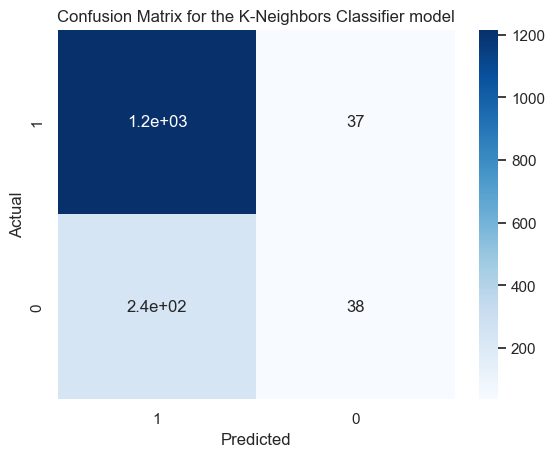

In [56]:
knn_model_results = modelling('K-Neighbors Classifier', knn, x_train_ros, y_train_ros,
                              x_test, y_test)
knn_model_results

Fine tuning the KNN model using hyperparameter tuning.........

In [57]:
# Declaring the feature space...
random_grid = {
    'n_neighbors': range(3, 7), 'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean']
}
random_estimator_knn = RandomizedSearchCV(estimator=knn,
                                          param_distributions=random_grid,
                                          n_iter=5,
                                          scoring='f1',
                                          n_jobs=-1,
                                          verbose=1,
                                          random_state=1,
                                          )

In [58]:
random_estimator_knn.fit(x_train_ros, y_train_ros)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(estimator=KNeighborsClassifier(), n_iter=5, n_jobs=-1,
                   param_distributions={'metric': ['minkowski', 'euclidean'],
                                        'n_neighbors': range(3, 7),
                                        'weights': ['uniform', 'distance']},
                   random_state=1, scoring='f1', verbose=1)

MODEL: Fine Tuned K-Neighbors Classifier
--------------------------------------------------------------------------------
Training Accuracy is : 100%
Test Accuracy is 84%
The classification report : 
               precision    recall  f1-score   support

           0       0.86      0.96      0.91      1301
           1       0.39      0.12      0.19       232

    accuracy                           0.84      1533
   macro avg       0.62      0.54      0.55      1533
weighted avg       0.79      0.84      0.80      1533
 


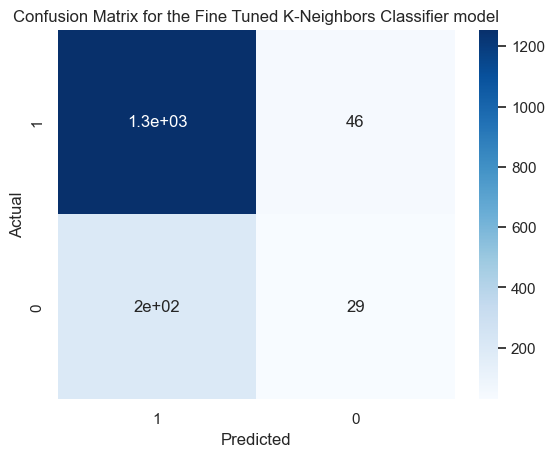

In [59]:
# Testing the performance of the fine tuned KNN model on the test set.
knn_tuned_model_results = modelling('Fine Tuned K-Neighbors Classifier', random_estimator_knn.best_estimator_, x_train_ros, y_train_ros,
                                    x_test, y_test)
knn_tuned_model_results

Hyper parameter tuning increased the accuracy on the test set from 82 to 84 but it made it performed poorly on all other performance metrics.

### Logistic Regression Model

In [60]:
log = LogisticRegression(random_state=105)
log_cv = cross_validate(log, x_train_ros, y_train_ros)
print(log_cv)

Mean Training F1 Score: 0.8955265872555715
Mean Training Recall Score: 0.892467392243241
Mean Training Precision Score: 0.9019031374663967
Mean Training Accuracy Score: 0.8975994803855245
None


MODEL: Logistic Regression
--------------------------------------------------------------------------------
Training Accuracy is : 90%
Test Accuracy is 88%
The classification report : 
               precision    recall  f1-score   support

           0       0.91      0.96      0.93      1373
           1       0.32      0.15      0.20       160

    accuracy                           0.88      1533
   macro avg       0.61      0.56      0.57      1533
weighted avg       0.85      0.88      0.86      1533
 


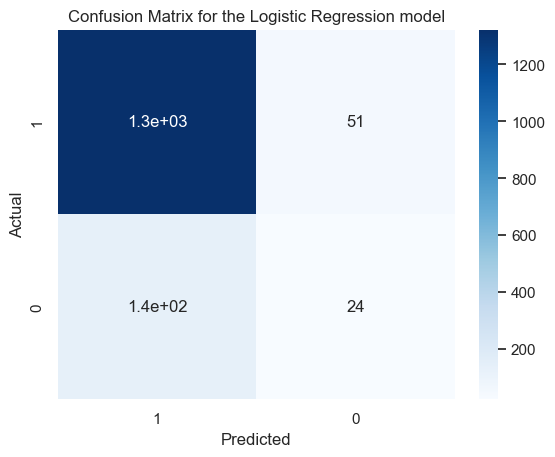

In [61]:
log_model_results = modelling('Logistic Regression', log, x_train_ros, y_train_ros,
                              x_test, y_test)
log_model_results

Searching for optimum parameters for the logistic regression model.

In [62]:
max_iter = [100, 1000]
solver = ['lbfgs', 'newton-cg', 'liblinear']
warm_start = [True, False]
C = np.arange(0, 1, 0.1)
# Creating a dictionary of parameters for the randomizedsearchcv algorithm to iterate over
random_grid = {
    'max_iter': max_iter,
    'warm_start': warm_start,
    'solver': solver,
    'C': C,
}
random_estimator_log = RandomizedSearchCV(estimator=log,
                                          param_distributions=random_grid,
                                          n_iter=5,
                                          scoring='f1',
                                          n_jobs=-1,
                                          verbose=1,
                                          random_state=1,
                                          )

In [63]:
random_estimator_log.fit(x_train_ros, y_train_ros)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(estimator=LogisticRegression(random_state=105), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'C': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'max_iter': [100, 1000],
                                        'solver': ['lbfgs', 'newton-cg',
                                                   'liblinear'],
                                        'warm_start': [True, False]},
                   random_state=1, scoring='f1', verbose=1)

MODEL: Fine Tuned Logistic Regression
--------------------------------------------------------------------------------
Training Accuracy is : 90%
Test Accuracy is 88%
The classification report : 
               precision    recall  f1-score   support

           0       0.91      0.96      0.93      1369
           1       0.36      0.16      0.23       164

    accuracy                           0.88      1533
   macro avg       0.63      0.56      0.58      1533
weighted avg       0.85      0.88      0.86      1533
 


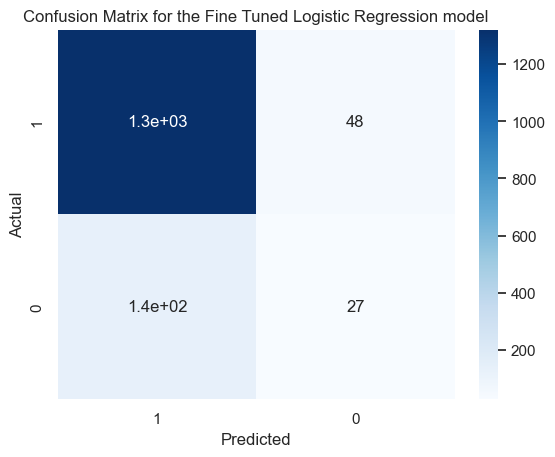

In [64]:
log_tuned_model_results = modelling('Fine Tuned Logistic Regression', random_estimator_log.best_estimator_, x_train_ros, y_train_ros,
                                    x_test, y_test)
log_tuned_model_results

The hyperparameter tuning of the logistic regression model didnot improve the accuracy of the original model, but it increased the precision and recall for the '0' class.

### Random Forest Classifier Model

In [65]:
rf = RandomForestClassifier(random_state=105)
rf_cv = cross_validate(rf, x_train_ros, y_train_ros)
rf_cv

Mean Training F1 Score: 0.9600609137001921
Mean Training Recall Score: 0.9621110823183899
Mean Training Precision Score: 0.9603419617184002
Mean Training Accuracy Score: 0.9610722874797295


MODEL: Random Forest Classifier
--------------------------------------------------------------------------------
Training Accuracy is : 100%
Test Accuracy is 92%
The classification report : 
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      1481
           1       0.07      0.10      0.08        52

    accuracy                           0.92      1533
   macro avg       0.52      0.52      0.52      1533
weighted avg       0.94      0.92      0.93      1533
 


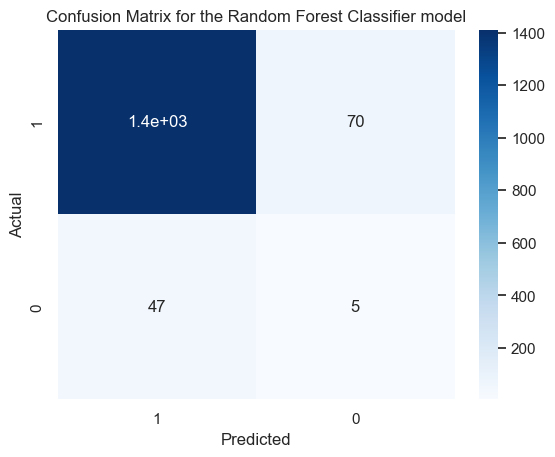

In [66]:
rf_model_results = modelling('Random Forest Classifier', rf, x_train_ros, y_train_ros,
                             x_test, y_test)
rf_model_results

Fine tuning the model using hyper parameter tuning....

In [67]:
random_grid = {
    "max_depth": [5, 7, 9, 11],
    "min_samples_leaf": [2, 3, 5, 7, 9],
    "min_samples_leaf": [2, 3, 4, 5, 6]
}
random_estimator_rf = RandomizedSearchCV(estimator=rf,
                                         param_distributions=random_grid,
                                         n_iter=3,
                                         scoring='f1',
                                         n_jobs=-1,
                                         cv=2,
                                         verbose=1,
                                         random_state=1,
                                         )

In [68]:
random_estimator_rf.fit(x_train_ros, y_train_ros)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(random_state=105),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'max_depth': [5, 7, 9, 11],
                                        'min_samples_leaf': [2, 3, 4, 5, 6]},
                   random_state=1, scoring='f1', verbose=1)

MODEL: Fine Tuned Random Forest
--------------------------------------------------------------------------------
Training Accuracy is : 97%
Test Accuracy is 90%
The classification report : 
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      1424
           1       0.20      0.14      0.16       109

    accuracy                           0.90      1533
   macro avg       0.57      0.55      0.55      1533
weighted avg       0.88      0.90      0.89      1533
 


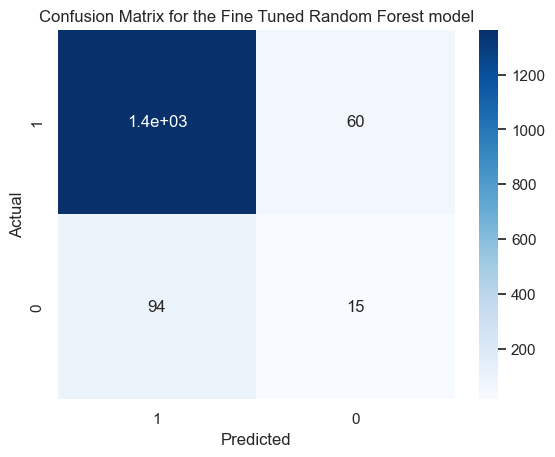

In [69]:
rf_tuned_model_results = modelling('Fine Tuned Random Forest', random_estimator_rf.best_estimator_, x_train_ros, y_train_ros,
                                   x_test, y_test)
rf_tuned_model_results

The hyperparameter tuning did not improve the accuracy of the model but instead reduced it. There is an increase in other model performance metrics such as recall and precision for the '0' class.

### Decision Tree Classifier

In [70]:
dt = DecisionTreeClassifier(random_state=105)
dt_cv = cross_validate(dt, x_train_ros, y_train_ros)
dt_cv

Mean Training F1 Score: 0.9262446937589749
Mean Training Recall Score: 0.9394843223633066
Mean Training Precision Score: 0.9173624729156508
Mean Training Accuracy Score: 0.9265419850869782


MODEL: Decision Tree Classifier
--------------------------------------------------------------------------------
Training Accuracy is : 100%
Test Accuracy is 89%
The classification report : 
               precision    recall  f1-score   support

           0       0.93      0.96      0.94      1408
           1       0.23      0.14      0.17       125

    accuracy                           0.89      1533
   macro avg       0.58      0.55      0.56      1533
weighted avg       0.87      0.89      0.88      1533
 


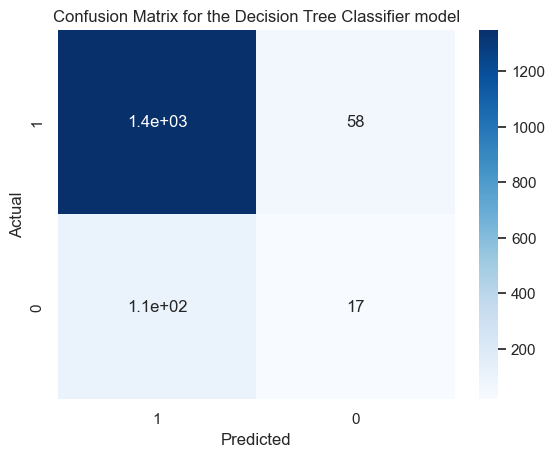

In [71]:
dt_model_results = modelling('Decision Tree Classifier', dt, x_train_ros, y_train_ros,
                             x_test, y_test)
dt_model_results

Now, we will try fine-tuning the model using hyperparametr tuning so that it can prodeuce optimum performance metrics, especially for the class '0' i.e class of patients without stroke.

In [72]:
random_grid = {
    "max_features": [5, 10, 20],
    "max_depth": [5, 7, 9, 11],
    "min_samples_leaf": [2, 3, 5, 7, 9],
    "min_samples_leaf": [2, 3, 4, 5, 6]
}
random_estimator_dt = RandomizedSearchCV(estimator=dt,
                                         param_distributions=random_grid,
                                         n_iter=3,
                                         scoring='f1',
                                         n_jobs=-1,
                                         cv=2,
                                         verbose=1,
                                         random_state=1,
                                         )

In [73]:
random_estimator_dt.fit(x_train_ros, y_train_ros)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


RandomizedSearchCV(cv=2, estimator=DecisionTreeClassifier(random_state=105),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'max_depth': [5, 7, 9, 11],
                                        'max_features': [5, 10, 20],
                                        'min_samples_leaf': [2, 3, 4, 5, 6]},
                   random_state=1, scoring='f1', verbose=1)

MODEL: Fine Tuned Decision Tree Classifier Model
--------------------------------------------------------------------------------
Training Accuracy is : 91%
Test Accuracy is 82%
The classification report : 
               precision    recall  f1-score   support

           0       0.84      0.97      0.90      1269
           1       0.41      0.12      0.18       264

    accuracy                           0.82      1533
   macro avg       0.63      0.54      0.54      1533
weighted avg       0.77      0.82      0.78      1533
 


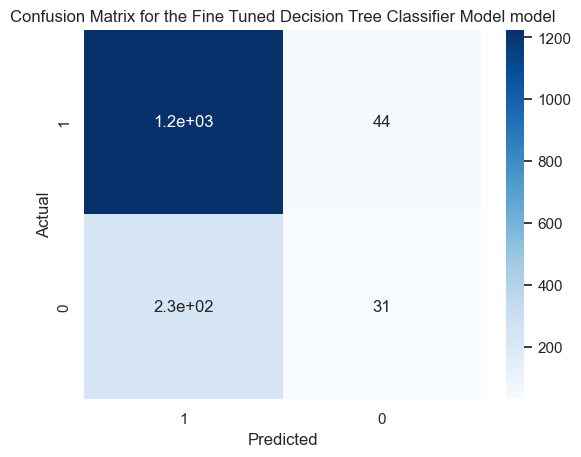

In [74]:
dt_tuned_model_results = modelling('Fine Tuned Decision Tree Classifier Model', random_estimator_dt.best_estimator_, x_train_ros, y_train_ros,
                                   x_test, y_test)
dt_tuned_model_results

Fine tuning this model did not perform better in fact, it performed worse than the default model.

### Support Vector Machine Classifier

In [75]:
svc = SVC(random_state=105)
svc_cv = cross_validate(svc, x_train_ros, y_train_ros)
svc_cv

Mean Training F1 Score: 0.7683618658911948
Mean Training Recall Score: 0.8086900751490024
Mean Training Precision Score: 0.7319919390162422
Mean Training Accuracy Score: 0.7562445985881073


MODEL: Support Vector Machine
--------------------------------------------------------------------------------
Training Accuracy is : 76%
Test Accuracy is 74%
The classification report : 
               precision    recall  f1-score   support

           0       0.73      0.99      0.84      1080
           1       0.81      0.13      0.23       453

    accuracy                           0.74      1533
   macro avg       0.77      0.56      0.54      1533
weighted avg       0.76      0.74      0.66      1533
 


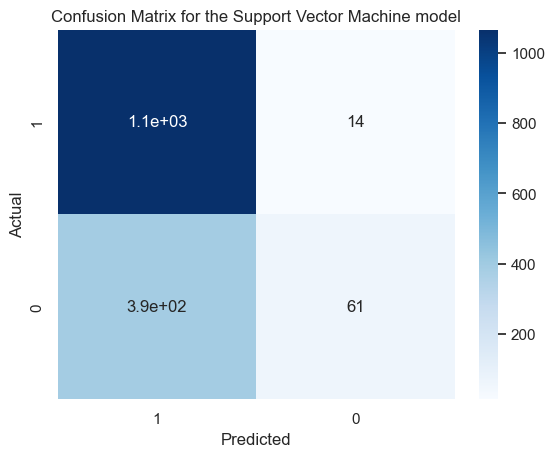

In [76]:
svc_model_results = modelling('Support Vector Machine', svc, x_train_ros, y_train_ros,
                              x_test, y_test)
svc_model_results

Now, we try using hyperparameter to find the optimum parameters for the model to make it perform  better.

In [77]:
params = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['linear', 'rbf']
}
random_estimator_svc = RandomizedSearchCV(estimator=svc,
                                          param_distributions=params,
                                          n_iter=3,
                                          scoring='f1',
                                          n_jobs=-1,
                                          cv=2,
                                          verbose=1,
                                          random_state=1,
                                          )

In [78]:
random_estimator_svc.fit(x_train_ros, y_train_ros)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


RandomizedSearchCV(cv=2, estimator=SVC(random_state=105), n_iter=3, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10],
                                        'gamma': [1, 0.1, 0.01],
                                        'kernel': ['linear', 'rbf']},
                   random_state=1, scoring='f1', verbose=1)

MODEL: Fine Tuned Support Vector Machine Model
--------------------------------------------------------------------------------
Training Accuracy is : 90%
Test Accuracy is 88%
The classification report : 
               precision    recall  f1-score   support

           0       0.91      0.96      0.94      1381
           1       0.31      0.15      0.20       152

    accuracy                           0.88      1533
   macro avg       0.61      0.56      0.57      1533
weighted avg       0.85      0.88      0.86      1533
 


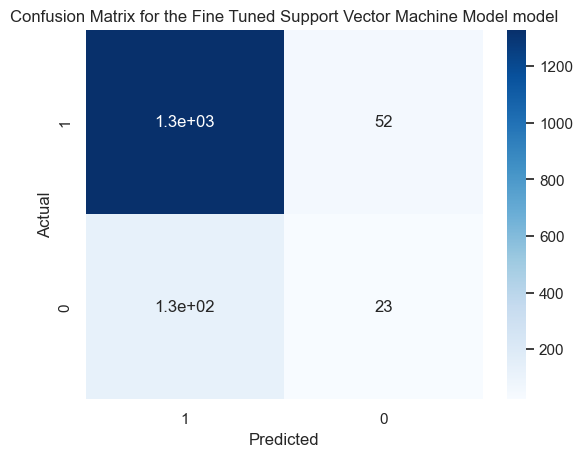

In [79]:
svc_tuned_model_results = modelling('Fine Tuned Support Vector Machine Model', random_estimator_svc.best_estimator_, x_train_ros, y_train_ros,
                                    x_test, y_test)
svc_tuned_model_results

Hyper parameter tuning increased the performance of the model for all performance metrics. The model's  performance on the '0' class is still poor as the average f1 score for the '0' class is 0.2.

### XGBOOST Classifier

In [80]:
xgb = XGBClassifier(random_state=105)
xgb_cv = cross_validate(xgb, x_train_ros, y_train_ros)
xgb_cv

Mean Training F1 Score: 0.9544294262551052
Mean Training Recall Score: 0.9574112464369009
Mean Training Precision Score: 0.9546942727453589
Mean Training Accuracy Score: 0.955783785999972


MODEL: XGBoost Classifier
--------------------------------------------------------------------------------
Training Accuracy is : 100%
Test Accuracy is 93%
The classification report : 
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      1487
           1       0.05      0.09      0.07        46

    accuracy                           0.93      1533
   macro avg       0.51      0.52      0.51      1533
weighted avg       0.94      0.93      0.93      1533
 


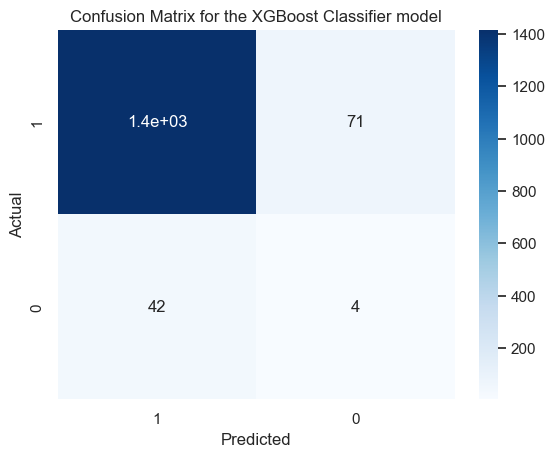

In [81]:
xgb_model_results = modelling('XGBoost Classifier', xgb, x_train_ros, y_train_ros,
                              x_test, y_test)
xgb_model_results

In [82]:
random_grid = {
    'learning_rate': [0.01, 0.05],
    'gamma': [0, 0.5],
    'reg_alpha': [0, 0.5],
    'reg_lambda': [0.5, 1],
}
random_estimator_xgb = RandomizedSearchCV(estimator=xgb,
                                          param_distributions=random_grid,
                                          n_iter=3,
                                          scoring='accuracy',
                                          cv=2,
                                          n_jobs=-1,
                                          verbose=1,
                                          random_state=1,
                                          )

Now, we try to optimize the model's performance using hyperparameter tuning....

In [83]:
random_estimator_xgb.fit(x_train_ros, y_train_ros)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


RandomizedSearchCV(cv=2,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=105, ...),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'gamma': [0, 0.5],
                                        'learning_rate': [0.01, 0.05],
                                        'reg_alpha': [0, 0.5],
                                        'reg_lambda': [0.5, 1]},
                   random_state=1, scoring='accuracy', verbose=1)

MODEL: Fine Tuned XGBoost Model
--------------------------------------------------------------------------------
Training Accuracy is : 96%
Test Accuracy is 89%
The classification report : 
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      1403
           1       0.21      0.12      0.16       130

    accuracy                           0.89      1533
   macro avg       0.57      0.54      0.55      1533
weighted avg       0.86      0.89      0.87      1533
 


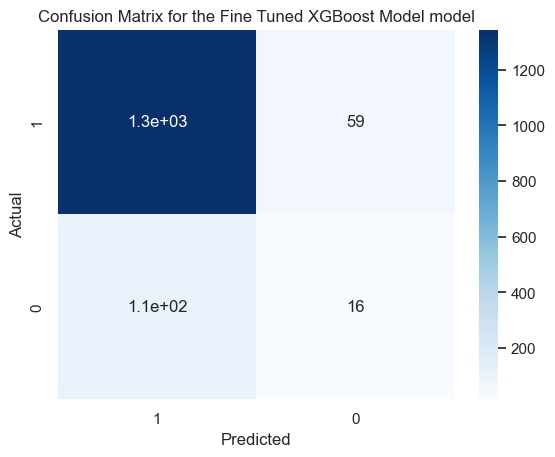

In [84]:
xgb_tuned_model_results = modelling('Fine Tuned XGBoost Model', random_estimator_xgb.best_estimator_, x_train_ros, y_train_ros,
                                    x_test, y_test)
xgb_tuned_model_results

The hyperparameter tuning did not improve the performance on the original model as the fine tuned model showed lesser accuracy than the original model.

## Summary and Findings


- Stroke seems prevalent in the older demographics.
- Higher BMI and average blood glucose is associated with occurence of stroke.
- Men are at higher risk of developing stroke than women.
- Hypertension is associated with the occurence of stroke.
- The dataset showed huge amount of class imbalance which made our models fail to accurately classify patients with stroke. This can easily be solved by the provision of data showing little or no class imbalance to retrain and validate our models.
- In general, the tree and ensemble algorithms performed better than all other forms of algorithms.